In [1]:
import numpy as np
import pandas as pd
import datetime
from pylab import rcParams
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
import math
from datetime import date

/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


In [4]:
df = pd.read_csv("df_RNN.csv", index_col=[0])

In [5]:
df.head()

,date,open,high,low,adj_close**,sentiments
99,2019-05-29,1127.52,1129.10,1108.22,1116.46,0.199160
98,2019-05-30,1115.54,1123.13,1112.12,1117.95,0.024045
97,2019-05-31,1101.29,1109.60,1100.18,1103.63,0.199324
96,2019-06-03,1065.50,1065.50,1025.00,1036.23,0.140989
95,2019-06-04,1042.90,1056.05,1033.69,1053.05,0.139237


In [6]:
test_size = 0.2
N = 9
lstm_units = 128
dropout_prob = 1
optimizer = 'nadam'
epochs = 50
batch_size = 8

In [7]:
df.sort_values(by='date', inplace=True, ascending=True)

In [8]:
df.head()

,date,open,high,low,adj_close**,sentiments
99,2019-05-29,1127.52,1129.10,1108.22,1116.46,0.199160
98,2019-05-30,1115.54,1123.13,1112.12,1117.95,0.024045
97,2019-05-31,1101.29,1109.60,1100.18,1103.63,0.199324
96,2019-06-03,1065.50,1065.50,1025.00,1036.23,0.140989
95,2019-06-04,1042.90,1056.05,1033.69,1053.05,0.139237


Text(0, 0.5, 'USD')

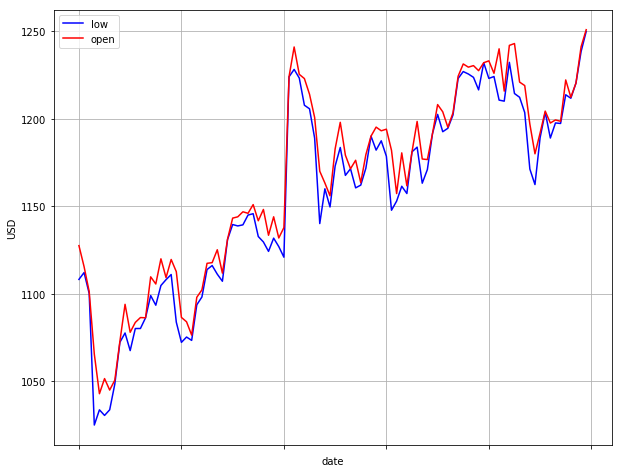

In [9]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = df.plot(x='date', y='low', style='b-', grid=True)
ax = df.plot(x='date', y='open', style='r-', grid=True, ax=ax)
ax.set_xlabel('date')
ax.set_ylabel("USD")

In [10]:
num_test = int(len(df) * test_size)
num_train = len(df) - num_test

In [11]:
num_test, num_train

(20, 80)

In [22]:
train = df[:num_train][['date','open','high','low','adj_close**','sentiments']]

In [23]:
test = df[num_train:][['date','open','high','low','adj_close**','sentiments']]

In [24]:
train.shape

(80, 6)

In [25]:
test.shape

(20, 6)

In [26]:
train.head()

,date,open,high,low,adj_close**,sentiments
99,2019-05-29,1127.52,1129.10,1108.22,1116.46,0.199160
98,2019-05-30,1115.54,1123.13,1112.12,1117.95,0.024045
97,2019-05-31,1101.29,1109.60,1100.18,1103.63,0.199324
96,2019-06-03,1065.50,1065.50,1025.00,1036.23,0.140989
95,2019-06-04,1042.90,1056.05,1033.69,1053.05,0.139237


In [27]:
test.head()

,date,open,high,low,adj_close**,sentiments
19,2019-09-20,1233.12,1243.32,1223.08,1229.93,0.130114
18,2019-09-23,1226.00,1239.09,1224.17,1234.03,0.104840
17,2019-09-24,1240.00,1246.74,1210.68,1218.76,0.193752
16,2019-09-25,1215.82,1248.30,1210.09,1246.52,0.143535
15,2019-09-26,1241.96,1245.00,1232.27,1241.39,0.081002


In [28]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train[['open','high','low','adj_close**','sentiments']]))

In [29]:
train_scaled

array([[-0.43957695, -0.56993947, -0.62502017, -0.638981  ,  0.90654431],
       [-0.66999938, -0.68031698, -0.55202101, -0.61144986, -0.7716522 ],
       [-0.94408283, -0.93046904, -0.77551073, -0.87604439,  0.90811093],
       [-1.63246504, -1.74582052, -2.18270982, -2.12141247,  0.3490626 ],
       [-2.06715177, -1.9205387 , -2.02005273, -1.81062477,  0.33227166],
       [-1.90097065, -1.96676044, -2.07994948, -2.01073361,  0.22467657],
       [-2.02695286, -2.07880194, -2.01986556, -1.9715618 , -2.17061338],
       [-1.91847352, -1.64561179, -1.7447149 , -1.57060501, -0.97492568],
       [-1.48859527, -1.24366755, -1.29698675, -1.30564094, -2.11614899],
       [-1.08468283, -1.07116801, -1.19815712, -1.33631321,  0.66390031],
       [-1.39204096, -1.46053995, -1.38645751, -1.3675398 ,  0.51322112],
       [-1.28356162, -1.21574961, -1.1504269 , -1.15061664,  0.39078372],
       [-1.23009131, -1.24311288, -1.15005255, -1.2138089 ,  0.84751715],
       [-1.23278406, -1.12312125, -1.0

In [30]:
train_scaled.shape

(80, 5)

In [31]:
def get_x_y(data, N, offset):
    # Split data into x (features) and y (target)
    
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i,1])
    
    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [32]:
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)

In [33]:
x_train_scaled.shape

(71, 9, 5)

In [34]:
y_train_scaled.shape

(71,)

In [35]:
y_train_scaled

array([-1.07116801, -1.46053995, -1.21574961, -1.24311288, -1.12312125,
       -0.80493079, -0.97853965, -0.73596796, -0.66219806, -0.70120921,
       -0.84264773, -1.23793605, -1.34646469, -1.45924574, -0.9678162 ,
       -0.89034857, -0.61320302, -0.5000522 , -0.6276242 , -0.58972237,
       -0.33051086, -0.12676543, -0.23270566, -0.168365  , -0.02489272,
       -0.02896023, -0.2278986 , -0.16244861, -0.38227921, -0.24084068,
       -0.2944579 , -0.3369819 ,  1.95284307,  1.61671858,  1.38560989,
        1.36952472,  1.37155848,  0.86848106,  0.28312895,  0.3703956 ,
        0.34229278,  0.83353743,  0.8126452 ,  0.46283908,  0.82928503,
        0.41365915,  0.29422217,  0.4214244 ,  0.87014505,  0.6680636 ,
        0.72242037,  0.70411656,  0.63145598,  0.17644918,  0.41550802,
        0.30494562,  0.6680636 ,  0.71317602,  0.49852226,  0.43547581,
        0.98200166,  0.96314319,  1.11068298,  0.92579602,  1.15875359,
        1.51484587,  1.49672695,  1.47232187,  1.38801342,  1.39

In [36]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_scaled.shape[1],5)))
model.add(Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(LSTM(units=50))
model.add(Dropout(1)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train_scaled, y_train_scaled, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 5s - loss: 0.2974


In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 50)             11200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 31,451
Trainable params: 31,451
Non-trainable params: 0
_________________________________________________________________


In [39]:
def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i] - mu_list[i-offset]) / std_list[i-offset])
        y.append(data[i,1])
    
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

In [40]:
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df[['open','high','low','adj_close**','sentiments']]), N, num_train)

In [41]:
x_test_scaled.shape

(20, 9, 5)

In [42]:
y_test.shape

(20,)

In [56]:
x_test_scaled

array([[[ 0.46027867,  0.49296627,  0.43702961,  0.46111629,
         -1.99910736],
        [ 0.44219834,  0.47253652,  0.44103384,  0.46436462,
         -1.99935865],
        [ 0.45907331,  0.49827801,  0.45660131,  0.49331358,
         -1.99951626],
        [ 0.50175106,  0.53762571,  0.49913606,  0.52207867,
         -1.99941169],
        [ 0.51615404,  0.53562359,  0.50728753,  0.53292687,
         -1.99926009],
        [ 0.5124154 ,  0.53292687,  0.50442736,  0.51605189,
         -1.99904159],
        [ 0.51421321,  0.5236109 ,  0.50050485,  0.51165949,
         -1.9996012 ],
        [ 0.50830902,  0.52485712,  0.48587715,  0.51831959,
         -1.99909158],
        [ 0.51760455,  0.54289659,  0.51752283,  0.53119034,
         -1.99937262]],

       [[ 0.436233  ,  0.46649867,  0.43507128,  0.4583463 ,
         -1.99948841],
        [ 0.45306764,  0.49217863,  0.45060155,  0.48722607,
         -1.99964564],
        [ 0.49564339,  0.53143229,  0.49303463,  0.51592241,
         -1.9

In [43]:
y_test

array([1243.32, 1239.09, 1246.74, 1248.3 , 1245.  , 1244.02, 1226.  ,
       1231.23, 1196.98, 1189.06, 1211.44, 1218.2 , 1206.08, 1208.35,
       1215.  , 1228.39, 1226.33, 1247.33, 1254.74, 1263.32])

In [47]:
def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1], 5)))
    model.add(Dropout(dropout_prob))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    #Do Prediction
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1, 1)) + np.array(mu_cv_list).reshape(-1, 1)
    
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

In [48]:
def get_mape(y_true, y_pred):
    # Mean Absolute Percentage Error
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [49]:
rmse, mape, est = train_pred_eval_model(x_train_scaled, \
                                        y_train_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list, \
                                        lstm_units=128, \
                                        dropout_prob=1, \
                                        optimizer='nadam', \
                                        epochs=50, \
                                        batch_size=8)

In [50]:
rmse

439.09583560087924

In [51]:
mape

35.68370594746303

In [52]:
est

array([[1671.19652578],
       [1675.52548761],
       [1681.29877428],
       [1684.69767835],
       [1685.14301036],
       [1684.78991039],
       [1684.90240784],
       [1684.88424422],
       [1684.0874818 ],
       [1679.32153505],
       [1673.55123125],
       [1667.47459935],
       [1662.24911615],
       [1657.15868312],
       [1649.98828587],
       [1644.24545645],
       [1641.64421419],
       [1640.07533674],
       [1646.423963  ],
       [1655.77540609]])

In [53]:
y_test

array([1243.32, 1239.09, 1246.74, 1248.3 , 1245.  , 1244.02, 1226.  ,
       1231.23, 1196.98, 1189.06, 1211.44, 1218.2 , 1206.08, 1208.35,
       1215.  , 1228.39, 1226.33, 1247.33, 1254.74, 1263.32])

Text(0, 0.5, 'USD')

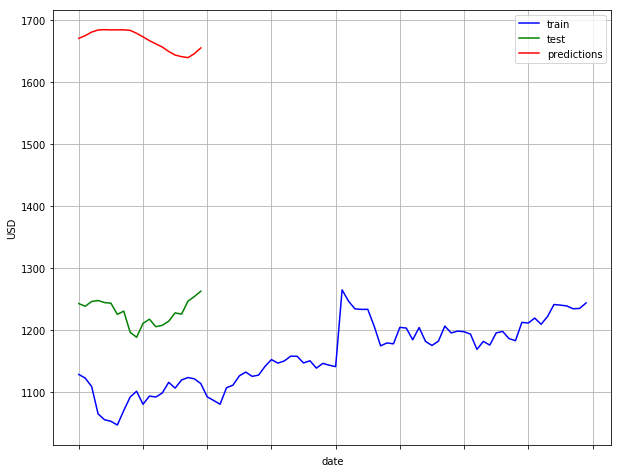

In [63]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train:]['date']})

ax = train.plot(x='date', y='high', style='b-', grid=True)
ax = test.plot(x='date', y='high', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

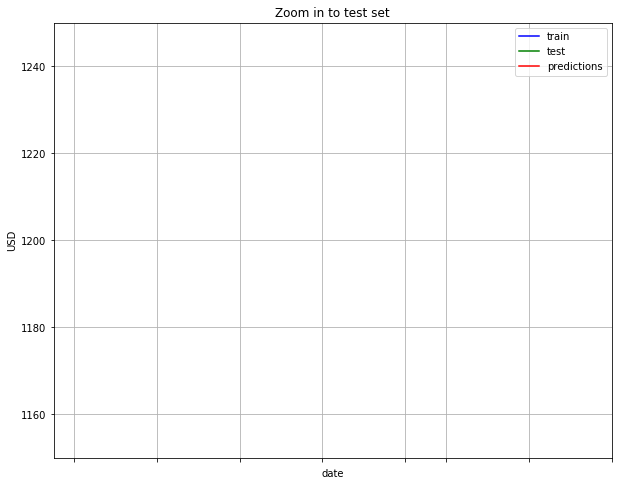

In [55]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='high', style='b-', grid=True)
ax = test.plot(x='date', y='high', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 9, 12), date(2019, 10, 9)])
ax.set_ylim([1150, 1250])
ax.set_title("Zoom in to test set")

In [57]:
train

,date,open,high,low,adj_close**,sentiments
99,2019-05-29,1127.52,1129.10,1108.22,1116.46,0.199160
98,2019-05-30,1115.54,1123.13,1112.12,1117.95,0.024045
97,2019-05-31,1101.29,1109.60,1100.18,1103.63,0.199324
96,2019-06-03,1065.50,1065.50,1025.00,1036.23,0.140989
95,2019-06-04,1042.90,1056.05,1033.69,1053.05,0.139237
94,2019-06-05,1051.54,1053.55,1030.49,1042.22,0.128009
93,2019-06-06,1044.99,1047.49,1033.70,1044.34,-0.121932
92,2019-06-07,1050.63,1070.92,1048.40,1066.04,0.002834
91,2019-06-10,1072.98,1092.66,1072.32,1080.38,-0.116249
90,2019-06-11,1093.98,1101.99,1077.60,1078.72,0.173841


In [58]:
test

,date,open,high,low,adj_close**,sentiments
19,2019-09-20,1233.12,1243.32,1223.08,1229.93,0.130114
18,2019-09-23,1226.00,1239.09,1224.17,1234.03,0.104840
17,2019-09-24,1240.00,1246.74,1210.68,1218.76,0.193752
16,2019-09-25,1215.82,1248.30,1210.09,1246.52,0.143535
15,2019-09-26,1241.96,1245.00,1232.27,1241.39,0.081002
14,2019-09-27,1243.01,1244.02,1214.45,1225.09,0.204399
13,2019-09-30,1220.97,1226.00,1212.30,1219.00,0.206465
12,2019-10-01,1219.00,1231.23,1203.58,1205.10,0.150039
11,2019-10-02,1196.98,1196.98,1171.29,1176.63,-0.018772
10,2019-10-03,1180.00,1189.06,1162.43,1187.83,0.193018


In [59]:
est_df

,date,est
19,2019-09-20,1671.196526
18,2019-09-23,1675.525488
17,2019-09-24,1681.298774
16,2019-09-25,1684.697678
15,2019-09-26,1685.143010
14,2019-09-27,1684.789910
13,2019-09-30,1684.902408
12,2019-10-01,1684.884244
11,2019-10-02,1684.087482
10,2019-10-03,1679.321535


In [61]:
df.dtypes

date            object
open           float64
high           float64
low            float64
adj_close**    float64
sentiments     float64
dtype: object